decision tree 

Data Loading

In [9]:
import pandas as pd

# Paths to your training data files
amazon_fashion_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/AMAZON_FASHION.json'
all_beauty_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/All_Beauty.json'
clothing_shoes_jewelry_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Clothing_Shoes_and_Jewelry.json'


# Number of rows to read from each file
n_rows = 25000

# Load a subset of each training dataset
amazon_fashion = pd.read_json(amazon_fashion_path, lines=True, nrows=n_rows)
all_beauty = pd.read_json(all_beauty_path, lines=True, nrows=n_rows)
clothing_shoes_jewelry = pd.read_json(clothing_shoes_jewelry_path, lines=True, nrows=n_rows)

# Concatenate the datasets
training_data = pd.concat([amazon_fashion, all_beauty, clothing_shoes_jewelry])

Text Preprocessing 

In [10]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        tokens = word_tokenize(text)
        lemmatized_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word not in stop_words])
        return lemmatized_text
    else:
        return ""

# Apply the preprocessing to your training data
training_data['processed_reviewText'] = training_data['reviewText'].apply(preprocess_text)
training_data = training_data[training_data['processed_reviewText'] != ""]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Data Preparation 

In [11]:
from sklearn.model_selection import train_test_split

# Categorizing the ratings
def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

training_data['category'] = training_data['overall'].apply(cat_y)

feature without balance 

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Sentiment analysis using VADER on the original reviewText
analyzer = SentimentIntensityAnalyzer()
training_data['sentiment_score'] = training_data['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') #try some settings
tfidf_features = tfidf_vectorizer.fit_transform(training_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features = hstack([tfidf_features, training_data['sentiment_score'].values.reshape(-1, 1)])


# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(combined_features, training_data['category'], test_size=0.2, random_state=42)

Model Training with Hyperparameter Tuning without balance 

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearch
param_grid_decision_tree = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']  # Add class weights
}

# Creating GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_grid_decision_tree, cv=5, scoring='accuracy')

# Fitting the model
grid_search.fit(X_train, y_train)

# Getting the best estimator
decision_tree_model = grid_search.best_estimator_  # Use the best estimator

# Printing the best parameters
print("Best Parameters found by Grid Search:", grid_search.best_params_)


Best Parameters found by Grid Search: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


Model Evaluation

              precision    recall  f1-score   support

        high       0.93      0.81      0.86     12219
         low       0.39      0.69      0.49      1700
     neutral       0.14      0.17      0.16      1046

    accuracy                           0.75     14965
   macro avg       0.49      0.56      0.51     14965
weighted avg       0.81      0.75      0.77     14965

Accuracy: 0.7506849315068493
Recall: 0.5575432502163501
F1 Score: 0.5051475966762167


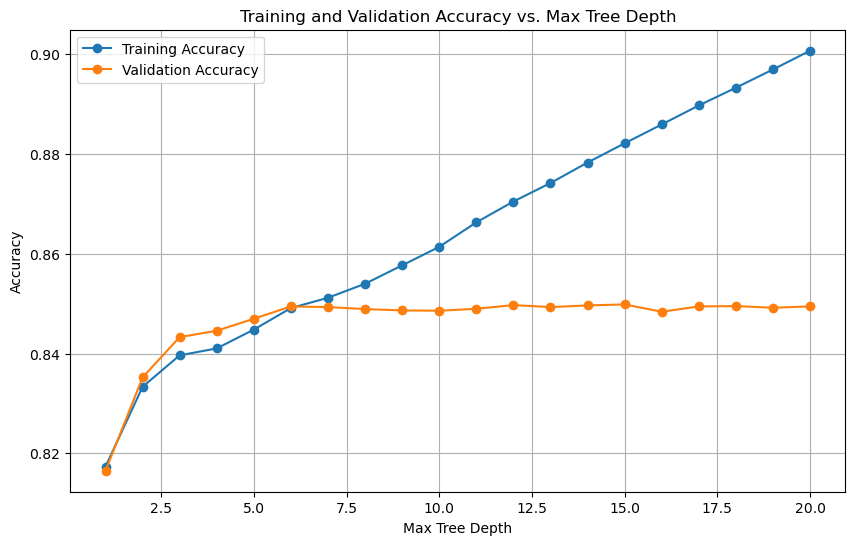

In [14]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

# Use the best estimator to predict on validation data
y_val_pred = decision_tree_model.predict(X_val)

# Classification report
print(classification_report(y_val, y_val_pred))

# Additional metrics
accuracy = accuracy_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred, average='macro')
f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"Accuracy: {accuracy}\nRecall: {recall}\nF1 Score: {f1}")



import matplotlib.pyplot as plt
import numpy as np

# Define a range of hyperparameter values to test (e.g., max_depth)
max_depths = range(1, 21)  # Adjust the range as needed

train_accuracies, val_accuracies = [], []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Training predictions
    train_preds = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    train_accuracies.append(train_accuracy)
    
    # Validation predictions
    val_preds = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    val_accuracies.append(val_accuracy)

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy vs. Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


model performance 

In [15]:
# Load test dataset
test_data = pd.read_json('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Luxury_Beauty.json', lines=True, nrows=25000)

# Preprocess the text data
test_data['processed_reviewText'] = test_data['reviewText'].apply(preprocess_text)

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
test_data['sentiment_score'] = test_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply the same TF-IDF vectorizer to the test data
# Assuming tfidf_vectorizer is already fitted to the training data
tfidf_features_test = tfidf_vectorizer.transform(test_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features_test = hstack([tfidf_features_test, test_data['sentiment_score'].values.reshape(-1, 1)])

# Categorize the ratings in the test data
test_data['category'] = test_data['overall'].apply(cat_y)

# Predict with the trained Decision Tree model
# Ensure decision_tree_model is your trained Decision Tree model
test_predictions = decision_tree_model.predict(combined_features_test)

# Evaluate the model's performance (optional)
print(classification_report(test_data['category'], test_predictions))


              precision    recall  f1-score   support

        high       0.89      0.83      0.86     19770
         low       0.43      0.57      0.49      3440
     neutral       0.14      0.16      0.15      1790

    accuracy                           0.74     25000
   macro avg       0.48      0.52      0.50     25000
weighted avg       0.77      0.74      0.76     25000

